In [24]:
%pip install pandas==1.5.3
import pandas as pd
import numpy as np
%matplotlib inline

from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor

print(pd.__version__)

1.5.3


In [25]:
!dir

 Volume in drive C is OS
 Volume Serial Number is 126D-D836

 Directory of C:\Users\smufl\Downloads\Day2\LST

27/04/2024  19:27    <DIR>          .
27/04/2024  19:26    <DIR>          ..
27/04/2024  16:58    <DIR>          .ipynb_checkpoints
27/04/2024  19:26           169,019 LST_forecasting.ipynb
27/04/2024  19:27            36,538 modis_ndvi_series_LST.csv
               2 File(s)        205,557 bytes
               3 Dir(s)  813,589,442,560 bytes free


In [ ]:
data = pd.read_csv('modis_ndvi_series_LST.csv')
data = data.filter(regex=r'loc|20')
data.head()

,20180101A,20180101D,20180102A,20180102D,20180103A,20180103D,20180104A,20180104D,20180105A,20180105D,...,20200623D,20200624A,20200624D,20200625A,20200625D,20200626A,20200626D,20200627A,20200627D,loc
0,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,1.65,1.5,1.64,1.5,1.62,-9999,-9999,1.49,1.66,L1
1,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,-9999,...,1.65,1.5,1.64,1.5,1.62,-9999,-9999,1.49,1.66,L2


# Computing annual means to remove seasonality.


In [27]:
# Melt the DataFrame to long format
melt = data.melt(id_vars='loc', var_name='day', value_name='NDVI')
melt = melt[(melt['NDVI'] > 0)]  # Remove negative values

# Extract year from the 'day' column
melt['year'] = melt['day'].str.extract('(\d{4})\d{4}', expand=False).astype(int)

# Ensure 'year' column contains only numeric values
melt = melt.dropna(subset=['year'])  # Drop rows with missing year values

# Computing annual means
year_mean = melt.groupby(['year', 'loc']).mean().reset_index()
print(year_mean)

   year loc      NDVI
0  2018  L1  1.496345
1  2018  L2  1.496345
2  2019  L1  1.478664
3  2019  L2  1.478664
4  2020  L1  1.452186
5  2020  L2  1.452186


C:\Users\smufl\AppData\Local\Temp\ipykernel_15664\1059754221.py:12: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  year_mean = melt.groupby(['year', 'loc']).mean().reset_index()


# Split dataset

In [28]:
year_mean.index

RangeIndex(start=0, stop=6, step=1)

In [29]:
split_point = 28
melt_train = year_mean[year_mean.index < split_point].copy()
melt_valid = year_mean[year_mean.index >= split_point].copy()

In [30]:
melt_train

,year,loc,NDVI
0,2018,L1,1.496345
1,2018,L2,1.496345
2,2019,L1,1.478664
3,2019,L2,1.478664
4,2020,L1,1.452186
5,2020,L2,1.452186


In [31]:
melt_valid

,year,loc,NDVI


# Creating Features and Targets

In [32]:
melt_train['lead1'] = melt_train.groupby("loc")['NDVI'].shift(-1).fillna(0)
melt_train['lead2'] = melt_train.groupby("loc")['NDVI'].shift(-2).fillna(0)
melt_train['lead3'] = melt_train.groupby("loc")['NDVI'].shift(-3).fillna(0)
melt_train['lead4'] = melt_train.groupby("loc")['NDVI'].shift(-4).fillna(0)
melt_train['lead5'] = melt_train.groupby("loc")['NDVI'].shift(-5).fillna(0)

melt_train['lag1'] = melt_train.groupby("loc")['NDVI'].shift(1).fillna(0)
melt_train['lag2'] = melt_train.groupby("loc")['NDVI'].shift(2).fillna(0)
melt_train['lag3'] = melt_train.groupby("loc")['NDVI'].shift(3).fillna(0)

melt_train["diff_1"] = melt_train.groupby("loc")['NDVI'].diff(1).fillna(0)

melt_train

,year,loc,NDVI,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1
0,2018,L1,1.496345,1.478664,1.452186,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
1,2018,L2,1.496345,1.478664,1.452186,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000
2,2019,L1,1.478664,1.452186,0.000000,0.0,0.0,0.0,1.496345,0.000000,0.0,-0.017680
3,2019,L2,1.478664,1.452186,0.000000,0.0,0.0,0.0,1.496345,0.000000,0.0,-0.017680
4,2020,L1,1.452186,0.000000,0.000000,0.0,0.0,0.0,1.478664,1.496345,0.0,-0.026478
5,2020,L2,1.452186,0.000000,0.000000,0.0,0.0,0.0,1.478664,1.496345,0.0,-0.026478


In [33]:
melt_valid['lead1'] = melt_valid.groupby("loc")['NDVI'].shift(-1)
melt_valid['lead2'] = melt_valid.groupby("loc")['NDVI'].shift(-2)
melt_valid['lead3'] = melt_valid.groupby("loc")['NDVI'].shift(-3)
melt_valid['lead4'] = melt_valid.groupby("loc")['NDVI'].shift(-4)
melt_valid['lead5'] = melt_valid.groupby("loc")['NDVI'].shift(-5)

melt_valid['lag1'] = melt_valid.groupby("loc")['NDVI'].shift(1)
melt_valid['lag2'] = melt_valid.groupby("loc")['NDVI'].shift(2)
melt_valid['lag3'] = melt_valid.groupby("loc")['NDVI'].shift(3)

melt_valid["diff_1"] = melt_valid.groupby("loc")['NDVI'].diff(1)

melt_valid

,year,loc,NDVI,lead1,lead2,lead3,lead4,lead5,lag1,lag2,lag3,diff_1


In [34]:
# drop rows without target values

#melt_train = melt_train.dropna(subset=['lead1','lead2','lead3','lead4','lead5'])
#melt_train


# Train the model

In [35]:
features = ['NDVI', 'lag1', 'lag2', 'lag3','diff_1']

In [36]:
import time

start_time = time.time()

imputer = SimpleImputer()
Xtr = imputer.fit_transform(melt_train[features])
ytr = melt_train[['lead1','lead2','lead3','lead4','lead5']]

mdl = RandomForestRegressor(n_estimators=100, random_state=0, n_jobs=6) #
mdl.fit(Xtr, ytr)
# Check the shape of the transformed feature matrix Xtr
print("Number of samples (n):", Xtr.shape[0])
print("Number of features (m):", Xtr.shape[1])

# overall complexity of training a Random Forest model - O(k * n * m * log(n)), 
# where k is the number of estimators, n is the number of samples, and m is the number of features.

# for this dataset, O(100 * n * m * log(n))
# Number of samples (n): 18
# Number of features (m): 5

end_time = time.time()

# Calculate the duration
duration_seconds = end_time - start_time
print("Training time:", duration_seconds, "seconds")

Number of samples (n): 6
Number of features (m): 5
Training time: 0.3079416751861572 seconds


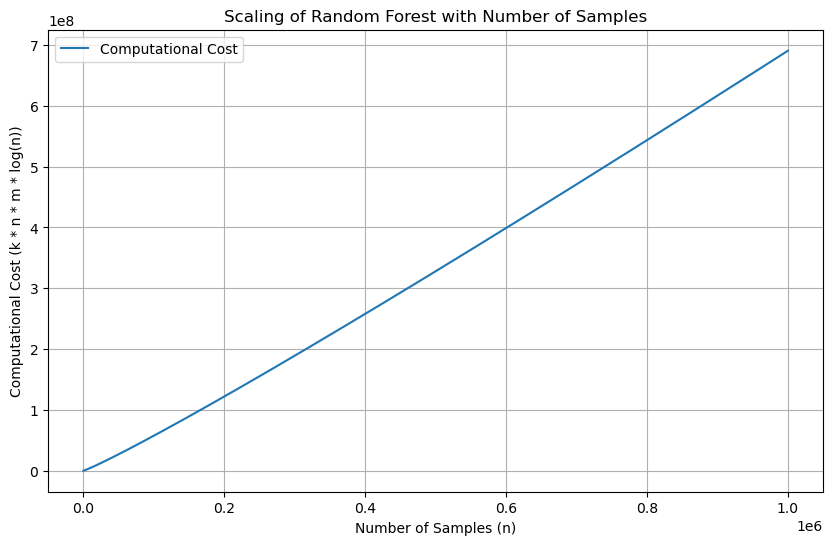

In [3]:
import numpy as np
import matplotlib.pyplot as plt

def plot_rf_scaling(num_estimators, num_features, max_samples):
    n_samples = np.arange(1, max_samples, 100)  # Sample size range from 1 to max_samples with steps of 100
    computational_cost = num_estimators * n_samples * num_features * np.log(n_samples)

    plt.figure(figsize=(10, 6))
    plt.plot(n_samples, computational_cost, label='Computational Cost')
    plt.xlabel('Number of Samples (n)')
    plt.ylabel('Computational Cost (k * n * m * log(n))')
    plt.title('Scaling of Random Forest with Number of Samples')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_rf_scaling(num_estimators=10, num_features=5, max_samples=1000000)

# Predicting NDVI  

In [38]:
Xval = imputer.transform(melt_valid[features])
preds = mdl.predict(Xval)

ValueError: Found array with 0 sample(s) (shape=(0, 5)) while a minimum of 1 is required by SimpleImputer.

In [ ]:
preds

In [ ]:
preds.shape

In [ ]:
L1_2022_2026=preds[10]
L2_2022_2026=preds[11]

In [ ]:
year_arr=np.arange(2022,2027).reshape(-1,1)
L1_arr=L1_2022_2026.reshape(-1,1)
L1_arr_new=np.concatenate((year_arr, L1_arr),axis=1)
df = pd.DataFrame(L1_arr_new, columns = ['year','NDVI'])
df.loc[:,'year']=df.loc[:,'year'].astype(int)
L1_NDVI=year_mean.loc[year_mean['loc'] == 'L1']
# L1_NDVI.loc[:,'year']=L1_NDVI.loc[:,'year'].astype(int)
L1_NDVI=pd.concat([L1_NDVI, df], ignore_index=True)
L1_NDVI

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L1_NDVI['year'], L1_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df['year'], df['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 1",fontsize=20)
ax.grid()
ax.legend();


In [ ]:
L2_arr=L2_2022_2026.reshape(-1,1)
L2_arr_new=np.concatenate((year_arr, L2_arr),axis=1)
df2 = pd.DataFrame(L2_arr_new, columns = ['year','NDVI'])
L2_NDVI=year_mean.loc[year_mean['loc'] == 'L2']
L2_NDVI=pd.concat([L2_NDVI, df2], ignore_index=True)
L2_NDVI.loc[:,'year']=L2_NDVI.loc[:,'year'].astype(int)
L2_NDVI

In [ ]:
fig, ax = plt.subplots(figsize=(18,8))
ax.plot(L2_NDVI['year'], L2_NDVI['NDVI'],lw=2, label='Historical')
ax.plot(df2['year'], df2['NDVI'],lw=2, label="Forecast ")
ax.set_xlabel('Year',fontsize=16)
ax.set_ylabel('NDVI',fontsize=14)
ax.set_title("NDVI Forcast_Location 2",fontsize=20)
ax.grid()
ax.legend();


# reference to codes at:

https://github.com/ledmaster/english_tutorials/blob/main/multiple_time_series/workshop_notebook.ipynb
